# Random Forest

In [1]:
import numpy as np
from collections import Counter



def gini_impurity(y):
    """
    Calculate the Gini Impurity for an array of class labels.
    """
    if len(y) == 0:
        return 0
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

def best_split(X, y, feature_indices):
    """
    Find the best split for the data in X, y using only the features in feature_indices.
    Returns:
      - best_feature: index of the best feature to split on
      - best_threshold: threshold value for the split
      - best_gain: the impurity gain from the best split
      - best_left_idx, best_right_idx: indices of the data points going to left and right splits
    """
    best_feature = None
    best_threshold = None
    best_gain = -np.inf
    best_left_idx = None
    best_right_idx = None
    parent_impurity = gini_impurity(y)
    n_samples = X.shape[0]

    if n_samples < 2:
        return None, None, None, None, None

    for feature in feature_indices:
        # Get all unique values for this feature as potential thresholds
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            # Split the dataset into left/right groups
            left_idx = np.where(X[:, feature] <= threshold)[0]
            right_idx = np.where(X[:, feature] > threshold)[0]
            if len(left_idx) == 0 or len(right_idx) == 0:
                continue  # skip useless splits

            # Calculate impurity for children nodes
            left_impurity = gini_impurity(y[left_idx])
            right_impurity = gini_impurity(y[right_idx])
            # Compute weighted impurity of the split
            weighted_impurity = (len(left_idx) / n_samples) * left_impurity + \
                                (len(right_idx) / n_samples) * right_impurity
            gain = parent_impurity - weighted_impurity

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
                best_left_idx = left_idx
                best_right_idx = right_idx

    return best_feature, best_threshold, best_gain, best_left_idx, best_right_idx

class Node:
    """
    A node in the decision tree.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        # For internal nodes:
        self.feature = feature      # index of feature to split on
        self.threshold = threshold  # threshold value for the split
        self.left = left            # left child node (X[feature] <= threshold)
        self.right = right          # right child node (X[feature] > threshold)
        # For leaf nodes:
        self.value = value          # class label (for classification)

# -------------------------------
# Decision Tree Implementation
# -------------------------------

def build_tree(X, y, max_depth=None, min_samples_split=2, n_features=None, depth=0):
    """
    Recursively build a decision tree.
    - X: features (numpy array of shape [n_samples, n_features])
    - y: labels (numpy array of shape [n_samples])
    - max_depth: maximum depth of the tree (None means unlimited)
    - min_samples_split: minimum number of samples required to split
    - n_features: number of random features to consider at each split (if None, use all)
    - depth: current depth of the tree
    """
    n_samples, n_total_features = X.shape
    num_labels = len(np.unique(y))

    # Stopping conditions: max depth reached, pure node, or too few samples to split.
    if (max_depth is not None and depth >= max_depth) or num_labels == 1 or n_samples < min_samples_split:
        # Create a leaf node with the most common label
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)

    # Randomly select subset of features if specified
    if n_features is None:
        feature_indices = list(range(n_total_features))
    else:
        feature_indices = np.random.choice(n_total_features, n_features, replace=False)

    # Find the best split among the chosen features
    best = best_split(X, y, feature_indices)
    feature, threshold, gain, left_idx, right_idx = best

    # If no valid split was found, create a leaf node
    if feature is None or gain == 0:
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)

    # Recursively build the left and right subtrees
    left_subtree = build_tree(X[left_idx, :], y[left_idx],
                              max_depth=max_depth,
                              min_samples_split=min_samples_split,
                              n_features=n_features,
                              depth=depth+1)
    right_subtree = build_tree(X[right_idx, :], y[right_idx],
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               n_features=n_features,
                               depth=depth+1)

    return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)

def predict_tree(x, tree):
    """
    Predict the class label for a single sample x using the decision tree.
    """
    # If the node is a leaf, return its value
    if tree.value is not None:
        return tree.value
    # Otherwise, follow the appropriate branch
    if x[tree.feature] <= tree.threshold:
        return predict_tree(x, tree.left)
    else:
        return predict_tree(x, tree.right)

# -------------------------------
# Random Forest Implementation
# -------------------------------

class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None, bootstrap=True):
        """
        Parameters:
          - n_trees: Number of trees in the forest.
          - max_depth: Maximum depth for each tree.
          - min_samples_split: Minimum samples required to split a node.
          - n_features: Number of features to consider when looking for the best split.
                        (If None, then use all features.)
          - bootstrap: Whether to use bootstrap samples when building trees.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.trees = []

    def fit(self, X, y):
        """
        Build the forest of trees from the training set.
        """
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            # Create a bootstrap sample
            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
                X_sample = X[indices]
                y_sample = y[indices]
            else:
                X_sample = X
                y_sample = y
            # Build a decision tree on the sample
            tree = build_tree(X_sample, y_sample,
                              max_depth=self.max_depth,
                              min_samples_split=self.min_samples_split,
                              n_features=self.n_features)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict class labels for samples in X.
        Returns an array of predictions using majority voting.
        """
        # Collect predictions from each tree
        tree_preds = np.array([[predict_tree(x, tree) for tree in self.trees] for x in X])
        # Majority vote: for each sample, choose the most common class prediction
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(y_pred)


# Gradient Boosting

##  Problem Setup

Given a dataset $\{(x_i, y_i)\}_{i=1}^N$ with $x_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ (for regression), we aim to minimize:

$$
\mathbf{L}(F) = \sum_{i=1}^N L(y_i, F(x_i))
$$

where $F(x)$ is an additive model:

$$
F(x) = \sum_{m=0}^{M} \gamma_m h_m(x).
$$

## Functional Gradient Descent

Gradient descent in parameter space:

$$
\theta_m = \theta_{m-1} - \eta \nabla_\theta \mathbf{L}(\theta_{m-1}).
$$

Gradient descent in function space:

$$
F_m(x) = F_{m-1}(x) - \eta \nabla_F \mathbf{L}(F_{m-1}).
$$

At each step, we approximate the negative gradient:

$$
r_{im} = - \left. \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right|_{F = F_{m-1}}.
$$

and fit a weak learner:

$$
h_m = \arg \min_{h \in \mathbf{H}} \sum_{i=1}^N (r_{im} - h(x_i))^2.
$$

##  Algorithm

1. **Initialize:**  
   $F_0(x) = \arg \min_\gamma \sum_{i=1}^N L(y_i, \gamma)$.
2. **For** $m = 1, \dots, M$:
   - Compute pseudo-residuals:
     $$
     r_{im} = - \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}.
     $$
   - Fit weak learner $h_m$ to $\{(x_i, r_{im})\}$.
   - Find optimal weight:
     $$
     \gamma_m = \arg \min_{\gamma} \sum_{i=1}^N L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)).
     $$
   - Update:
     $$
     F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x).
     $$

## Example: Squared Error Loss

For $L(y, F) = \frac{1}{2} (y - F)^2$, we get:

$$
r_{im} = y_i - F_{m-1}(x_i).
$$

Thus, gradient boosting reduces to stage-wise residual fitting.

Regression MSE: 220.5909


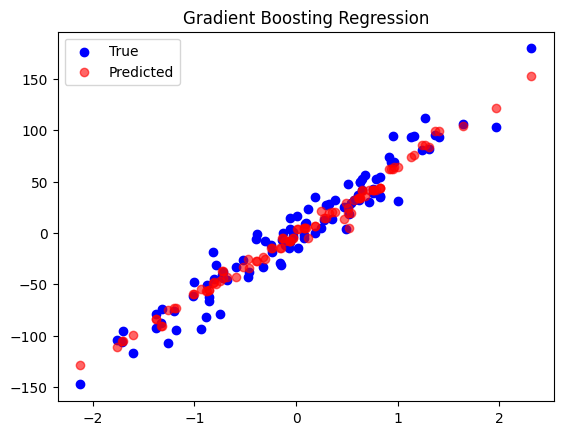

Classification Accuracy: 0.9600


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# ---- Regression Example ----
X_reg, y_reg = make_regression(n_samples=500, n_features=1, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print(f"Regression MSE: {mean_squared_error(y_test, y_pred):.4f}")

# Plot regression results
plt.scatter(X_test, y_test, color="blue", label="True")
plt.scatter(X_test, y_pred, color="red", alpha=0.6, label="Predicted")
plt.title("Gradient Boosting Regression")
plt.legend()
plt.show()

# ---- Classification Example ----
X_cls, y_cls = make_classification(n_samples=500, n_features=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
print(f"Classification Accuracy: {accuracy_score(y_test, y_pred):.4f}")


# XGBoost


## Objective Function

Given data $\{(x_i, y_i)\}_{i=1}^n$ and loss $\ell(y_i, \hat{y}_i)$, XGBoost minimizes:
$$
\mathcal{L}(F) = \sum_{i=1}^n \ell(y_i, \hat{y}_i) + \sum_{t=1}^T \Omega(f_t),
$$
where $\Omega(f_t)$ penalizes tree complexity:
$$
\Omega(f_t) = \gamma T_{\text{leaf}} + \frac{1}{2} \lambda \sum_{j=1}^{T_{\text{leaf}}} w_j^2.
$$

## Second-Order Approximation

For a new tree $f_t$, predictions update as:
$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i).
$$
Using Taylor expansion:
$$
\ell(y_i, \hat{y}_i^{(t)}) \approx \ell(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2,
$$
where
$$
g_i = \frac{\partial \ell}{\partial \hat{y}_i}, \quad h_i = \frac{\partial^2 \ell}{\partial \hat{y}_i^2}.
$$
Thus, the objective reduces to:
$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n (g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2) + \Omega(f_t).
$$

##  Tree Structure and Optimal Weights

Each tree assigns samples to leaves:
$$
f_t(x) = w_{q(x)},
$$
where $q(x)$ maps $x$ to a leaf index. Let:
$$
G_j = \sum_{i \in I_j} g_i, \quad H_j = \sum_{i \in I_j} h_i.
$$
Then the objective simplifies to:
$$
\mathcal{L}^{(t)} \approx \sum_{j=1}^{T_{\text{leaf}}} \left(G_j w_j + \frac{1}{2} H_j w_j^2 \right) + \gamma T_{\text{leaf}} + \frac{1}{2}\lambda \sum_{j=1}^{T_{\text{leaf}}} w_j^2.
$$

###  Computing Optimal Leaf Weights

To find the best leaf weights $\{ w_j \}$, we minimize the objective with respect to each $w_j$:
$$
\frac{\partial}{\partial w_j} \left(G_j w_j + \frac{1}{2} H_j w_j^2 + \frac{1}{2} \lambda w_j^2 \right) = G_j + (H_j + \lambda) w_j = 0.
$$
Solving for $w_j^*$:
$$
w_j^* = -\frac{G_j}{H_j + \lambda}.
$$

###  Gain from Adding a Tree

Plugging $w_j^*$ into the objective, the reduction in loss (gain) from adding a tree is:
$$
\text{Gain} = -\frac{1}{2} \sum_{j=1}^{T_{\text{leaf}}} \frac{G_j^2}{H_j + \lambda} + \gamma T_{\text{leaf}}.
$$
A larger gain means a better split.


## Split Finding

For a potential split into left ($I_L$) and right ($I_R$):
$$
\text{Gain} = \frac{1}{2} \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{G^2}{H + \lambda} \right) - \gamma.
$$
XGBoost picks the split maximizing this gain.


##  Mean Squared Error (MSE) Loss

For squared loss:
$$
\ell(y_i, \hat{y}_i) = \frac{1}{2} (y_i - \hat{y}_i)^2.
$$
Gradients:
$$
g_i = \frac{\partial}{\partial \hat{y}_i} \left[\frac{1}{2} (y_i - \hat{y}_i)^2\right] = \hat{y}_i - y_i,
$$
$$
h_i = \frac{\partial^2}{\partial \hat{y}_i^2} \left[\frac{1}{2} (y_i - \hat{y}_i)^2\right] = 1.
$$
Then:
$$
G_j = \sum_{i \in I_j} (\hat{y}_i - y_i), \quad H_j = |I_j|.
$$
Optimal leaf weight:
$$
w_j^* = -\frac{\sum_{i \in I_j} (\hat{y}_i - y_i)}{|I_j| + \lambda}.
$$



In [3]:
import xgboost as xgb
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# ------------------------------
# Load and preprocess MNIST data
# ------------------------------

# Fetch the MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Convert target labels to integers (they may come as strings)
y = y.astype(np.int32)

# Normalize pixel values to the range [0, 1]
X = X / 255.0

# Split the data into training and testing sets.
# Here we use 60,000 samples for training and 10,000 for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

# ------------------------------
# Train using XGBClassifier
# ------------------------------

# Initialize the XGBClassifier.
# - 'objective' is set to 'multi:softprob' to get class probabilities.
# - 'num_class' is set to 10 (digits 0 through 9).
# - 'use_label_encoder' is disabled to avoid warnings (XGBoost 1.3+).
# - 'eval_metric' is set to 'mlogloss' (multiclass log-loss).
clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=10,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,  # Avoids deprecation warnings in newer versions.
    eval_metric='mlogloss'
)

# Set up an evaluation set for early stopping.
eval_set = [(X_test, y_test)]

# Train the model with early stopping if there is no improvement after 10 rounds.
clf.fit(X_train, y_train,  eval_set=eval_set, verbose=True)

# Make predictions on the test set.
y_pred = clf.predict(X_test)

# Evaluate and print the accuracy.
accuracy = accuracy_score(y_test, y_pred)
print("XGBClassifier Accuracy on MNIST: {:.2f}%".format(accuracy * 100))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:47:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.96966
[1]	validation_0-mlogloss:1.73759
[2]	validation_0-mlogloss:1.55649
[3]	validation_0-mlogloss:1.41114
[4]	validation_0-mlogloss:1.28926
[5]	validation_0-mlogloss:1.18460
[6]	validation_0-mlogloss:1.09344
[7]	validation_0-mlogloss:1.01279
[8]	validation_0-mlogloss:0.94136
[9]	validation_0-mlogloss:0.87810
[10]	validation_0-mlogloss:0.82030
[11]	validation_0-mlogloss:0.76680
[12]	validation_0-mlogloss:0.72017
[13]	validation_0-mlogloss:0.67736
[14]	validation_0-mlogloss:0.63858
[15]	validation_0-mlogloss:0.60291
[16]	validation_0-mlogloss:0.57040
[17]	validation_0-mlogloss:0.54046
[18]	validation_0-mlogloss:0.51265
[19]	validation_0-mlogloss:0.48705
[20]	validation_0-mlogloss:0.46426
[21]	validation_0-mlogloss:0.44253
[22]	validation_0-mlogloss:0.42272
[23]	validation_0-mlogloss:0.40413
[24]	validation_0-mlogloss:0.38703
[25]	validation_0-mlogloss:0.37096
[26]	validation_0-mlogloss:0.35607
[27]	validation_0-mlogloss:0.34261
[28]	validation_0-mlogloss:0.3

In [5]:
# Get the booster from the trained model
booster = clf.get_booster()

# Get feature importance scores by 'gain'
importance_gain = booster.get_score(importance_type='gain')
print("\nFeature Importances (Booster by Gain):")
for feature, score in importance_gain.items():
    print(f"{feature}: {score:.4f}")

# Optionally, get feature importance by 'weight'
importance_weight = booster.get_score(importance_type='weight')
print("\nFeature Importances (Booster by Weight):")
for feature, score in importance_weight.items():
    print(f"{feature}: {score}")



Feature Importances (Booster by Gain):
f43: 0.7801
f44: 0.8413
f45: 0.7382
f66: 209.5063
f67: 1.6797
f68: 3.6039
f69: 127.8272
f70: 15.3886
f71: 1.8951
f72: 0.7592
f73: 0.9414
f74: 6.9372
f75: 5.1857
f76: 8.0437
f91: 6.5453
f92: 24.6509
f93: 38.9295
f94: 97.2169
f95: 39.5877
f96: 102.5253
f97: 60.2205
f98: 43.0340
f99: 38.8932
f100: 196.0658
f101: 263.4692
f102: 3.2953
f103: 87.7536
f104: 67.5673
f105: 4.0847
f106: 32.6529
f107: 16.2954
f108: 22.9668
f117: 2.7063
f118: 0.6703
f119: 2.0409
f120: 3.2424
f121: 3.7695
f122: 5.1171
f123: 7.2589
f124: 44.1661
f125: 30.7760
f126: 44.9572
f127: 11.6935
f128: 10.1957
f129: 4.2349
f130: 4.4879
f131: 5.2684
f132: 4.9363
f133: 3.6200
f134: 5.3379
f135: 7.3938
f136: 1.1070
f137: 1.0595
f143: 0.8043
f144: 1.8642
f145: 1.1745
f146: 2.7340
f147: 4.4092
f148: 5.2990
f149: 18.7248
f150: 14.8288
f151: 7.3491
f152: 10.0654
f153: 18.9435
f154: 24.6561
f155: 139.4860
f156: 105.4243
f157: 12.6328
f158: 18.8394
f159: 8.1405
f160: 5.9956
f161: 3.2209
f162: 4.


# LightGBM

LightGBM is a high-performance gradient boosting framework optimized for **speed and memory efficiency**, particularly on **large datasets**. It introduces three major improvements over traditional boosting methods:

1. **Leaf-Wise Tree Growth**: Prioritizes splits that yield the highest loss reduction.
2. **Gradient-Based One-Side Sampling (GOSS)**: Efficiently reduces training data size while preserving crucial gradient information.
3. **Exclusive Feature Bundling (EFB)**: Compresses sparse high-dimensional data by bundling mutually exclusive features.



## Leaf-Wise Tree Growth

Instead of growing trees **depth-wise** (splitting all leaves at a given depth before moving to the next), LightGBM grows trees **leaf-wise (best-first)**:

- At each step, it **splits the leaf** that results in the highest loss reduction.
- This allows LightGBM to **focus on the most informative regions** of the feature space, leading to faster error minimization.
- **Potential drawback**: This can lead to **very deep trees** in localized regions, increasing the risk of overfitting. Regularization via `max_depth` and `num_leaves` is important.



##  Gradient-Based One-Side Sampling (GOSS)

###  High Training Cost on Large Data

Gradient boosting requires computing **gradients and Hessians for all data points** in every iteration to determine the best tree split. When datasets are **very large**, this becomes computationally expensive. A naive solution is **random subsampling**, but this risks discarding important information.

**GOSS** selectively **keeps** the most **informative** data points:

1. **Large-gradient examples** (hard-to-predict points) are **fully retained** because they contribute most to model updates.
2. **Small-gradient examples** (already well-predicted points) are **partially discarded** via random subsampling to save computation.
3. **Rescaling** ensures the overall gradient statistics remain correct.

By keeping the strongest gradient signals while reducing redundancy, LightGBM **reduces computational cost while maintaining accuracy**.



### The GOSS Algorithm

1. **Compute Gradients**:  
   Compute the first-order gradient $g_i$ for each training instance $i$.

2. **Sort by Gradient Magnitude**:  
   Rank all data points by $|g_i|$ in descending order.

3. **Select Two Sets**:  
   - $A$: The top $a$ fraction of data points with the **largest** gradients (fully retained).
   - $B'$: The bottom $(1-a)$ fraction of small-gradient points (potentially sampled).

4. **Sample from the Small-Gradient Set**:  
   From $B'$, randomly select a fraction $b$. The final training set becomes:
   $$
   S = A \cup B
   $$
   - $|A| = aN$ (all kept).
   - $|B| = b(1-a)N$ (randomly sampled).

5. **Re-Scale Small Gradients**:  
   To correct for sampling bias, each gradient in $B$ is **upweighted**:
   $$
   g'_i = \alpha g_i, \quad \text{where } \alpha = \frac{1-a}{b}.
   $$
   This ensures the total gradient sum remains unbiased.

6. **Train the Tree on the Reduced Set**:  
   LightGBM constructs the tree using only $S$, significantly reducing computation.


## Exclusive Feature Bundling (EFB)


Many real-world datasets have **thousands or millions of features**, particularly in:

- **One-hot encodings** of categorical variables.
- **Sparse matrices** (e.g., text data, recommender systems).

Processing these features **individually** is expensive in terms of **memory** and **computation**.


**EFB** identifies **mutually exclusive** features—features that are **never nonzero at the same time**—and **combines them into a single feature**.

For example:

| Feature 1 | Feature 2 | Feature 3 |
|-----------|-----------|-----------|
| 1         | 0         | 0         |
| 0         | 1         | 0         |
| 0         | 0         | 1         |

Since at most **one feature is nonzero per row**, these can be **merged into a single feature index**, reducing memory usage and computation.



###  How EFB Works

1. **Identify Groups of Exclusive Features**:
   - Construct a **graph** where each feature is a node.
   - Connect features if they **overlap too much** (i.e., are nonzero in the same rows).
   - Solve this as a **graph coloring** problem to minimize the number of feature groups.

2. **Bundle Features into a Shared Histogram**:
   - Each group of features is **combined into a single histogram**.
   - Within the histogram, each feature **uses a separate bin range**.
   - This drastically **reduces the number of histograms** needed.


In [6]:
import lightgbm as lgb

clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the classifier with early stopping.
# The eval_set allows the model to monitor performance on the test set and stop early if no improvement is seen.
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss', callbacks=[lgb.log_evaluation(period=1)]
)

# Make predictions on the test set and evaluate accuracy.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("LGBMClassifier Accuracy on MNIST: {:.2f}%".format(accuracy * 100))



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.730158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109563
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 632
[LightGBM] [Info] Start training from score -2.316515
[LightGBM] [Info] Start training from score -2.184506
[LightGBM] [Info] Start training from score -2.304086
[LightGBM] [Info] Start training from score -2.282619
[LightGBM] [Info] Start training from score -2.328074
[LightGBM] [Info] Start training from score -2.405911
[LightGBM] [Info] Start training from score -2.320410
[LightGBM] [Info] Start training from score -2.261603
[LightGBM] [Info] Start training from score -2.327903
[LightGBM] [Info] Start training from score -2.308603
[1]	valid_0's multi_logloss: 1.69342
[2]	valid_0's multi_logloss: 1.39071
[3]	valid_0's multi_logloss: 1.17623
[4]	valid_0's multi_logloss: 1.01611
[5]	valid_0's multi_

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBMClassifier Accuracy on MNIST: 97.59%


# HistGradientBoosting

The **HistGradientBoostingRegressor** is a histogram-based gradient boosting method that improves efficiency by binning continuous features and using histograms to optimize split selection. Its **three core innovations** are:

1. **Histogram-Based Binning**: Converts continuous feature values into discrete bins, reducing computation time.
2. **Efficient Split Finding**: Uses precomputed histograms to quickly determine optimal splits.
3. **Regularization via Binning**: The discretization process reduces noise and improves generalization.


## Binning the Features

Each feature $j$ is **mapped to a bin index** before training:
$$
b_{ij} = \mathcal{B}_j(x_{ij}) \in \{0, 1, \dots, B-1\}.
$$
where:
- $ x_{ij} $ is the raw feature value.
- $ \mathcal{B}_j $ is a **binning function** (e.g., uniform binning, quantile-based binning).
- $B$ is the **number of bins per feature** (typically much smaller than the number of unique values).

### Advantages of Binning

- **Computational Speed-Up**: The number of candidate splits is reduced from **unique values** to **only $B$ bins**.
- **Memory Efficiency**: Instead of storing raw feature values, we store **integer bin indices**, reducing memory usage.
- **Regularization Effect**: Binning smooths out **noise** in feature values, reducing overfitting.



# CatBoost

CatBoost is a gradient boosting framework optimized for **handling categorical data** efficiently and **reducing overfitting**. It introduces three main innovations:

1. **Oblivious (Symmetric) Decision Trees**: A highly regularized tree structure that ensures efficient computation.
2. **Ordered Target Statistics**: A principled method for encoding categorical features while preventing data leakage.
3. **Permutation-Driven Boosting**: A robust training procedure that stabilizes gradient estimates.



##  Oblivious (Symmetric) Decision Trees


A tree $T(x)$ of depth $d$ is defined by:
- A set of features $\{ f_1, f_2, \dots, f_d \}$ used for splitting.
- A set of thresholds $\{ t_1, t_2, \dots, t_d \}$.
- Leaf values $\{ l_0, l_1, \dots, l_{2^d - 1} \}$.

For an input $x$, the decision at level $j$ is:
$$
b_j(x) = \mathbb{I} \{ x_{f_j} \leq t_j \}.
$$
The leaf index is computed as:
$$
\ell(x) = \sum_{j=1}^{d} 2^{j-1} \, b_j(x).
$$
The final tree prediction is:
$$
T(x) = l_{\ell(x)}.
$$
This **regularizes the model**, reducing variance and **speeding up inference**, as tree traversal is **bitwise-computable**.



##  Ordered Target Statistics for Categorical Features

###  Handling Categorical Features

Most boosting frameworks convert categorical variables using **one-hot encoding** or **mean target encoding**. However:
- **One-hot encoding** creates **high-dimensional sparse features**.
- **Mean target encoding** suffers from **target leakage** if computed over the full dataset.

CatBoost **avoids leakage** by computing categorical transformations **in an online manner** using **ordered statistics**.



### Ordered Target Encoding

For a categorical feature $C$, each category $c_i$ is transformed into:
$$
\phi(c_i) = \frac{\sum_{j < i} \mathbb{I}\{ c_j = c_i \} y_j + a \gamma}{\sum_{j < i} \mathbb{I}\{ c_j = c_i \} + a}.
$$
where:
- **Summation is only over past samples** ($j < i$), ensuring **no information leakage**.
- **$a$** is a regularization parameter (prior weight).
- **$\gamma$** is a prior value (e.g., global mean of $y$).

This ensures that each sample **does not** see its own label during encoding.



### Permutation-Driven Encoding

Instead of **one fixed ordering**, CatBoost applies **multiple random permutations** of the dataset, computing:
$$
\phi_{\text{final}}(c_i) = \frac{1}{P} \sum_{p=1}^{P} \phi^{(p)}(c_i),
$$
where $\phi^{(p)}(c_i)$ is computed using permutation $p$.

**Benefits:**
- **Reduces variance** in categorical transformations.
- **Improves generalization** across different training orderings.




In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#########################################
# 1. Load and Preprocess the Adult Data #
#########################################

# Fetch the Adult dataset from OpenML as a DataFrame.
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame

# Replace missing values represented by "?" with NaN, then drop rows with missing values.
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# The target column is named "class" (income level)
target = "class"

# Separate features and target.
X = df.drop(columns=[target])
y = df[target]
# Identify categorical features: here, we assume that columns with object dtype are categorical.
cat_features = X.select_dtypes(include=['category']).columns.tolist()

# Perform a stratified train-test split to preserve class proportions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# For CatBoost, determine the indices of the categorical features (based on the training DataFrame).
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]



In [10]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [11]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [12]:
#########################################
# 2. Train and Evaluate CatBoost Model  #
#########################################

from catboost import CatBoostClassifier

# Initialize CatBoostClassifier.
# - iterations: Number of boosting rounds.
# - learning_rate: Shrinks the contribution of each tree.
# - depth: Maximum tree depth.
# - verbose: Prints progress messages.
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=50
)

# Train the model, passing the categorical feature indices.
cat_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Predict on the test set.
y_pred_cat = cat_model.predict(X_test)

# Evaluate CatBoost's performance.
acc_cat = accuracy_score(y_test, y_pred_cat)
print("CatBoost Accuracy:", acc_cat)


0:	learn: 0.6020203	total: 198ms	remaining: 1m 38s
50:	learn: 0.2928853	total: 9.54s	remaining: 1m 24s
100:	learn: 0.2817301	total: 19.5s	remaining: 1m 16s
150:	learn: 0.2741182	total: 30.3s	remaining: 1m 10s
200:	learn: 0.2691135	total: 39.6s	remaining: 59s
250:	learn: 0.2646418	total: 47.6s	remaining: 47.3s
300:	learn: 0.2607285	total: 52.3s	remaining: 34.6s
350:	learn: 0.2574644	total: 55.4s	remaining: 23.5s
400:	learn: 0.2535783	total: 58.7s	remaining: 14.5s
450:	learn: 0.2509368	total: 1m 3s	remaining: 6.88s
499:	learn: 0.2480219	total: 1m 6s	remaining: 0us
CatBoost Accuracy: 0.867551133222775


In [13]:

#########################################
# 3. Train and Evaluate LightGBM Model  #
#########################################

import lightgbm as lgb
from lightgbm import LGBMClassifier

# Initialize the LightGBM classifier.
lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model.
# For LightGBM, pass the categorical feature names.
lgb_model.fit(X_train, y_train, categorical_feature=cat_features,callbacks=[lgb.log_evaluation(period=1)])

# Predict on the test set.
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate LightGBM's performance.
acc_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Accuracy:", acc_lgb)


[LightGBM] [Info] Number of positive: 8966, number of negative: 27211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 36177, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247837 -> initscore=-1.110182
[LightGBM] [Info] Start training from score -1.110182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [16]:
# lgb_model is a fitted LGBMClassifier/Regressor
booster = lgb_model.booster_            # LightGBM Booster

# Importances (arrays aligned with feature names)
gain  = booster.feature_importance(importance_type='gain')
feat_names = booster.feature_name()

# Nicely formatted table
import pandas as pd
imp = pd.DataFrame({
    'feature': feat_names,
    'gain': gain,
}).sort_values('gain', ascending=False)

print(imp.to_string(index=False))


       feature         gain
  relationship 33471.681778
  capital-gain 22692.301018
 education-num 16749.617897
           age 13056.510353
marital-status 10872.191314
    occupation 10154.502033
        fnlwgt  9744.494319
  capital-loss  7862.270918
hours-per-week  7184.608974
     workclass  1427.895170
     education  1229.338049
native-country  1134.529562
           sex   978.564814
          race   173.511303
